In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import models, layers, optimizers
import warnings
warnings.simplefilter("ignore")
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2024-04-07 06:52:24.500794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 06:52:24.500889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 06:52:24.605942: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
BASE_DIR = '/kaggle/input/cassava-leaf-disease-classification/'
sub_dirs = os.listdir(BASE_DIR)

sub_dirs

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [3]:
train_df = pd.read_csv(BASE_DIR+'train.csv')

train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


<Axes: xlabel='label', ylabel='count'>

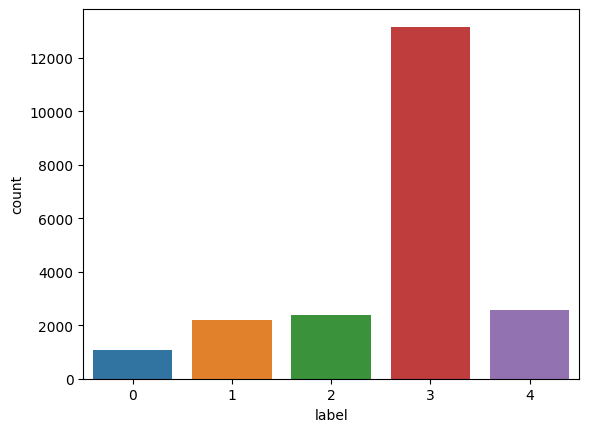

In [4]:
sns.countplot(train_df , x = 'label')

In [5]:
train_df['label'].value_counts()

label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64

In [6]:
y = train_df['label'].copy()

def flip_labels(y, percentage, class_to_flip):
    # find indices of class to flip
    class_indices = np.where(y == class_to_flip)[0]
    
    # calculate the number of labels to flip in this class
    num_flips = int(len(class_indices) * percentage)
    
    # randomly select indices from the class labels to flip
    flip_indices = np.random.choice(class_indices, num_flips, replace=False)
    
    # create a copy of the labels to avoid modifying the original data
    y_flipped = y.copy()
    
    # flip the labels at the selected indices
    y_flipped[flip_indices] = 1 - y_flipped[flip_indices]
    
    return y_flipped

percentage = .05
class_to_flip = 3
flipped_labels = flip_labels(y, percentage, class_to_flip)

train_df['label'] = flipped_labels.abs()    

In [7]:
train_df['label'].value_counts()

label
3    12501
2     3043
4     2577
1     2189
0     1087
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

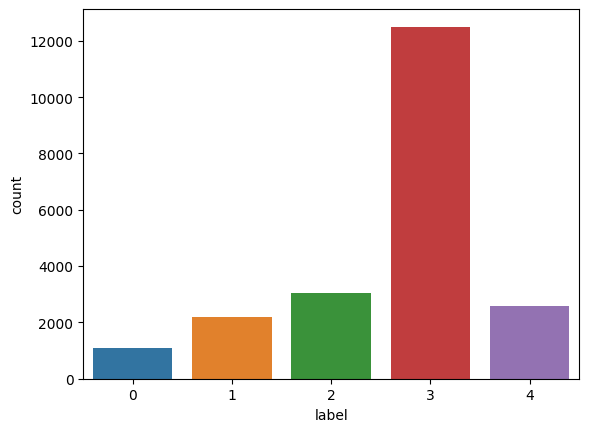

In [8]:
sns.countplot(train_df , x = 'label')

In [9]:
import json
with open(BASE_DIR+'label_num_to_disease_map.json') as label_maps:
    mapping = json.loads(label_maps.read())
    mapping = {int(k): v for k, v in mapping.items()}
mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [10]:
y_pred = [3] * len(train_df.label)
print("The baseline accuracy is {}".format(accuracy_score(y_pred, train_df.label)))

The baseline accuracy is 0.5842407814179558


In [11]:
Batch_size = 16
img_height, img_width = 300, 300

In [12]:
# Generating the training data from input data
train_df['label'] = train_df['label'].astype('str')
gen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2,
)

train_datagen = gen.flow_from_dataframe(
    train_df,
    directory = os.path.join(BASE_DIR, "train_images"),
    batch_size = Batch_size,
    target_size = (img_height, img_width),
    subset = "training",
    seed = 42,
    x_col = "image_id",
    y_col = "label",
    class_mode = "categorical"
)

Found 17118 validated image filenames belonging to 5 classes.


In [13]:
# Generating validation data from the input data

val_gen = ImageDataGenerator(
    validation_split = 0.2
)

val_datagen = val_gen.flow_from_dataframe(
    train_df,
    directory = os.path.join(BASE_DIR, "train_images"),
    batch_size = Batch_size,
    target_size = (img_height, img_width),
    subset = "validation",
    seed = 42,
    x_col = "image_id",
    y_col = "label",
    class_mode = "categorical"
)

Found 4279 validated image filenames belonging to 5 classes.


In [14]:
img, label = next(train_datagen)

In [15]:
label[0]

array([0., 0., 0., 1., 0.], dtype=float32)

In [16]:
Steps_per_train = float(train_datagen.n) / train_datagen.batch_size
Steps_per_val = float(val_datagen.n) / val_datagen.batch_size

In [17]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3

def create_model():
    model = models.Sequential()
    model.add(EfficientNetB3(include_top=False, weights='imagenet',
                             input_shape=(img_height, img_width, 3), drop_connect_rate=0.3))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(5, activation='softmax'))
    
    loss = tf.keras.losses.CategoricalCrossentropy(
        label_smoothing=0.0001,
        name='categorical_crossentropy'
    )
    optimizer = optimizers.Adam(learning_rate=1e-4)
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=["categorical_accuracy"])
    return model

model = create_model()
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [19]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


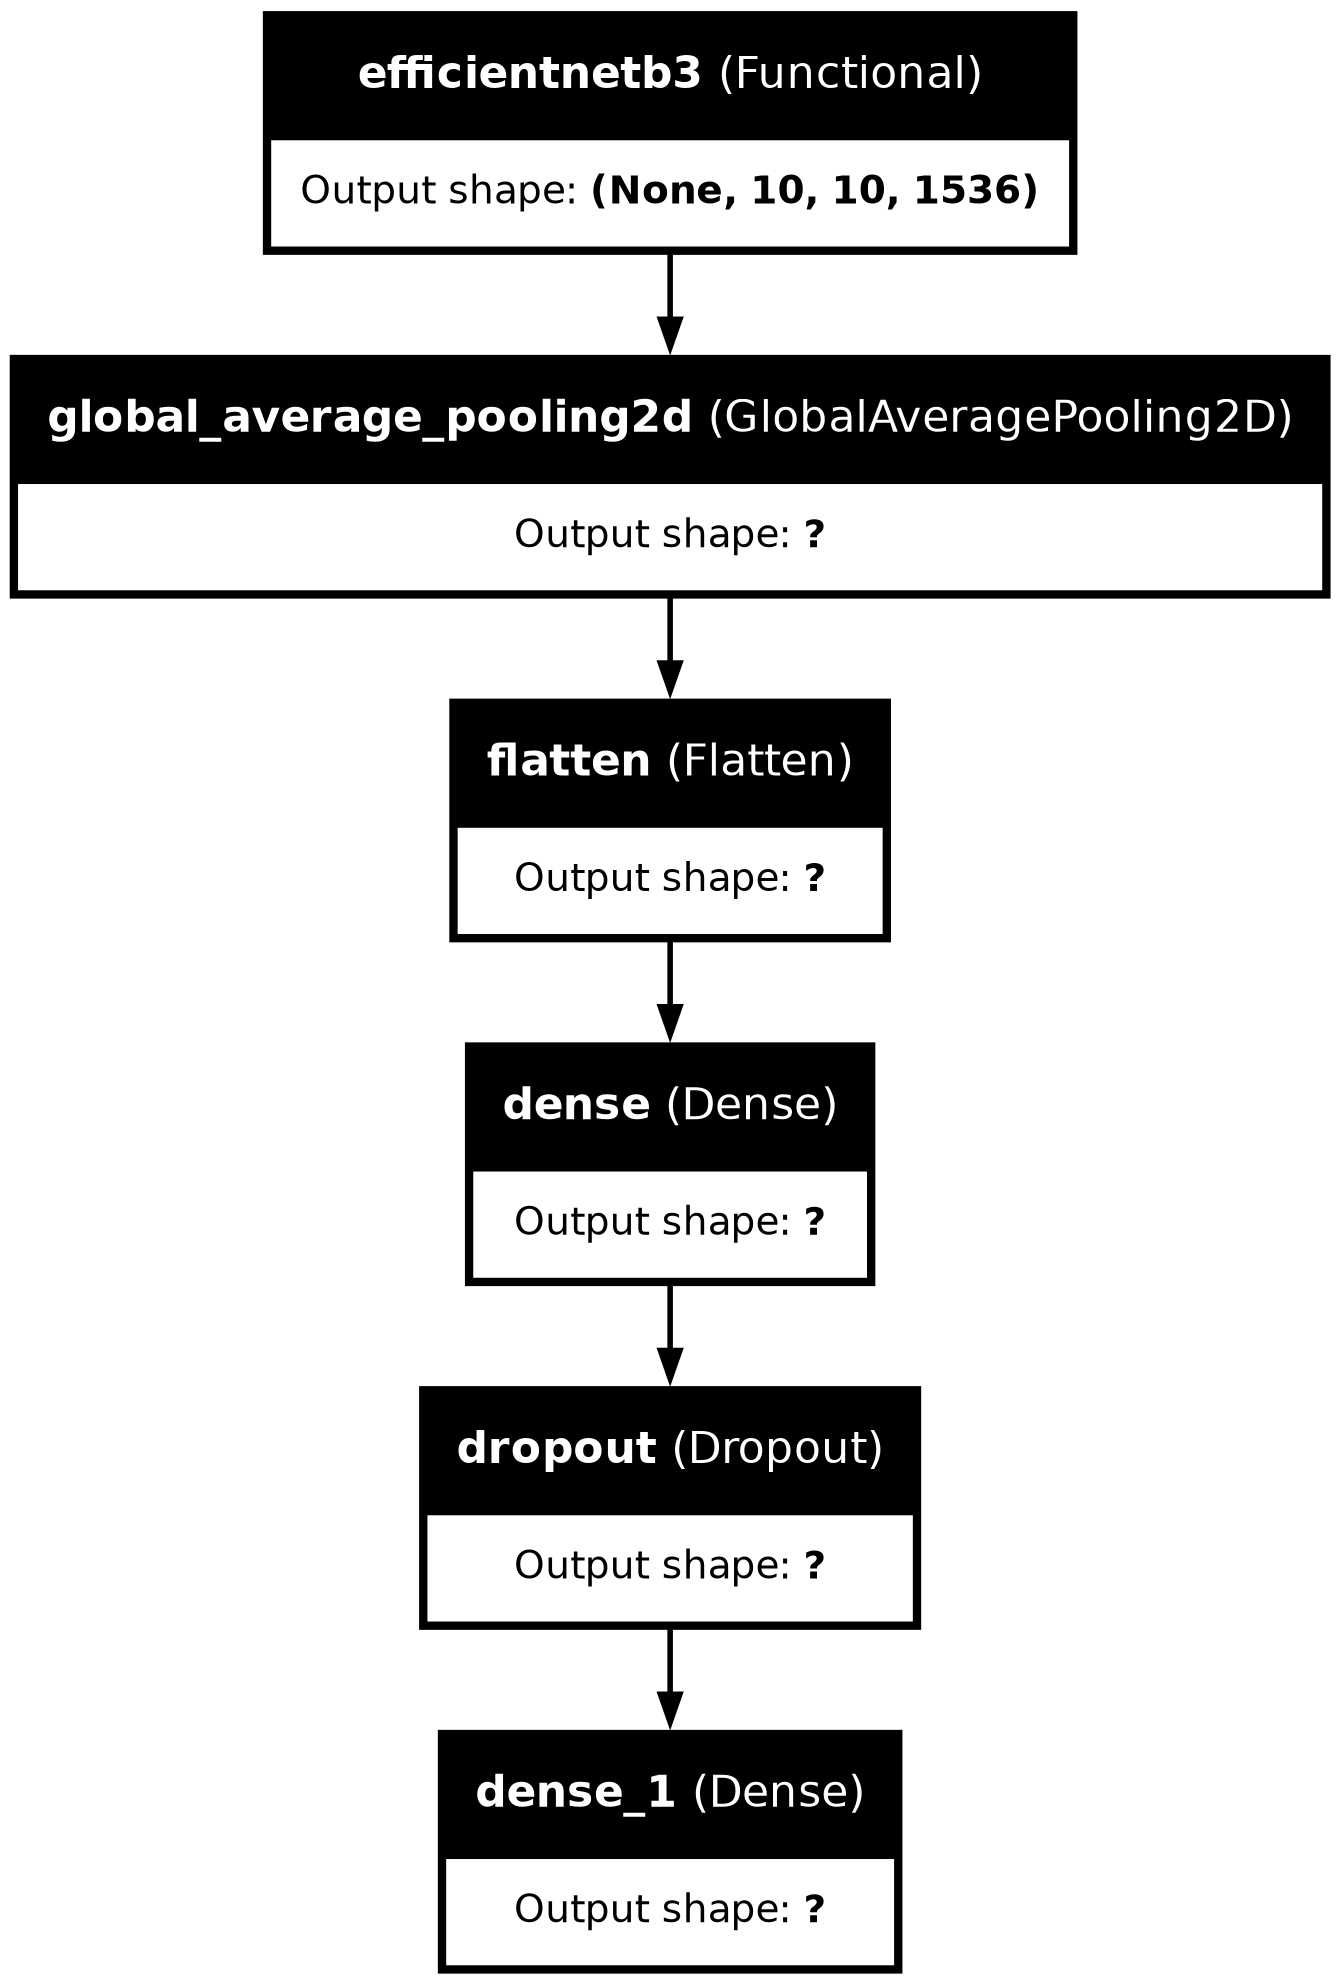

In [18]:
import pydot

# Build the model
model.build((None))

# Plot the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [19]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                            factor=0.2,
                                            mode = "min",
                                            min_lr=1e-6,
                                            patience=2, 
                                            verbose=1)

estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                       mode= "min",
                                       patience=3, 
                                       verbose=1,
                                       restore_best_weights=True)

history = model.fit(
    train_datagen,
    steps_per_epoch=int(Steps_per_train),
    epochs=5,
    verbose =1,
    validation_data=val_datagen,
    validation_steps=int(Steps_per_val),
    callbacks=[rlronp, estop]
)

Epoch 1/5


I0000 00:00:1712473052.083438      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712473052.256640      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1069/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - categorical_accuracy: 0.6742 - loss: 0.8790

W0000 00:00:1712473383.122508      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1069/1069 ━━━━━━━━━━━━━━━━━━━━ 534s 345ms/step - categorical_accuracy: 0.6743 - loss: 0.8789 - val_categorical_accuracy: 0.8111 - val_loss: 0.5666 - learning_rate: 1.0000e-04
Epoch 2/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - categorical_accuracy: 0.6875 - loss: 1.0004 - val_categorical_accuracy: 0.7143 - val_loss: 0.5769 - learning_rate: 1.0000e-04
Epoch 3/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 242s 226ms/step - categorical_accuracy: 0.8110 - loss: 0.5571 - val_categorical_accuracy: 0.8162 - val_loss: 0.5548 - learning_rate: 1.0000e-04
Epoch 4/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - categorical_accuracy: 0.8750 - loss: 0.5375 - val_categorical_accuracy: 0.7143 - val_loss: 0.3733 - learning_rate: 1.0000e-04
Epoch 5/5
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 242s 226ms/step - categorical_accuracy: 0.8414 - loss: 0.4738 - val_categorical_accuracy: 0.8151 - val_loss: 0.5521 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 4.
